## Section 1 - Imports & Setup


In [ ]:
!pip install timm torch torchvision
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 107.5 MB/s eta 0:00:00


In [1]:
# Converting to T4 GPU

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # List all GPU devices
if len(gpus) > 0:
    print('GPU Details:')
    for gpu in gpus:
        print(f'  {gpu}')
else:
    print('No GPU found.')

if len(gpus) > 0:
    try:
        # Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPU memory growth enabled - TensorFlow will use GPU for training')

        # Set the default device to GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f'Default training device set to: {gpus[0].name}')

    except RuntimeError as e:
        print(f'GPU configuration error: {e}')
else:
    print('No GPU detected. Training will run on CPU')

2025-11-26 20:49:59.648805: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-26 20:49:59.659860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 20:50:00.023682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 20:50:01.256738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

No GPU found.
No GPU detected. Training will run on CPU


2025-11-26 20:50:02.528848: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
import os
import random
import shutil
from typing import Dict, List

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import timm
import kornia.augmentation as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
import warnings


warnings.filterwarnings("ignore")

seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Section 2 - Swin Vision Transformer Model

**Model Overview**: Swin Transformer Tiny

* Architecture: swin_tiny_patch4_window7_224 is a Swin Transformer (Shifted Window Transformer).

* Patch-based: Input image is split into 4×4 patches (patch4), flattened, and fed into transformer blocks.

* Window-based Attention: Self-attention is computed locally within non-overlapping windows of size 7×7 (window7) and shifted across layers to capture cross-window information efficiently.

* Tiny version: ~28M parameters.
* loads weights from ImageNet-1K classification.

### 2.1 - Base Model Import and Overview

In [ ]:
# Load model
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=7  # FER classes
)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Input/output info
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)

print('='*100)
print('Input shape:')
print(dummy_input.shape)
print('='*100)

print('Output shape:')
print(output.shape)
print('='*100)

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Parameter count:')
print(f'Total: {total_params:,}, Trainable: {trainable_params:,}')
print('='*100)

# # First 3 layers
# print('First 3 layers:')
# for layer in list(model.children())[:2]:
#     print(layer)
# print('='*100)

# Last 3 layers
print('Last 3 layers:')
for layer in list(model.children())[-2:]:
    print(layer)
print('='*100)

layer_count = sum(1 for _ in model.modules())
print(f'total number of layers: {layer_count}')

# # Full model summary
# from torchsummary import summary
# summary(model, (3, 224, 224))


Input shape:
torch.Size([1, 3, 224, 224])
Output shape:
torch.Size([1, 7])
Parameter count:
Total: 27,524,737, Trainable: 27,524,737
Last 3 layers:
LayerNorm((768,), eps=1e-05, elementwise_affine=True)
ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Identity())
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=768, out_features=7, bias=True)
  (flatten): Identity()
)
total number of layers: 247
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2           [-1, 56, 56, 96]             192
        PatchEmbed-3           [-1, 56, 56, 96]               0
          Identity-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49,

##  Section 3 - Models Training preparation


### 3.1 - Data processing


In [5]:
from pathlib import Path

# ---------------- Preprocessing and augmentation setup ----------------#

# -------------------
# CONFIG
# -------------------
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
notebook_path: Path = Path().resolve()
root_dir: Path = notebook_path.parent
TRAIN_DIR = root_dir/"data"/"train"
VAL_DIR = root_dir/"data"/"val"
TEST_DIR = root_dir/"data"/"test"

# -------------------
# BASIC TRANSFORMS
# -------------------
# Used for Val and Test (no augmentation, just resizing/tensor)
basic_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

# -------------------
# DATASETS & LOADERS
# -------------------
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=basic_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=basic_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=basic_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes

# -------------------
# COMPUTE CLASS WEIGHTS
# -------------------
train_labels = [label for _, label in train_dataset]
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights_array, dtype=torch.float32).to(DEVICE)
class_weights_dict = dict(zip(range(len(class_weights)), class_weights_array))

print(f"Class Indices: {class_names}")
print(f"Weights: {class_weights_dict}")
print(f"Test Set Size: {len(test_dataset)}")

# -------------------
# GPU AUGMENTATIONS (KORNIA)
# -------------------
# Applied only to training batches on GPU
train_aug = torch.nn.Sequential(
    K.RandomResizedCrop(size=IMG_SIZE, scale=(0.9, 1.1)),
    K.RandomAffine(degrees=10.0, translate=(0.1, 0.1)),
    K.RandomHorizontalFlip()
).to(DEVICE)

# -------------------
# SAMPLE BATCH + AUGMENTATION
# -------------------
images, labels = next(iter(train_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

# Apply GPU augmentations
images_aug = train_aug(images)
print(f"Original batch shape: {images.shape}")
print(f"Augmented batch shape: {images_aug.shape}")

Class Indices: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0)}
Test Set Size: 6216
Original batch shape: torch.Size([32, 3, 224, 224])
Augmented batch shape: torch.Size([32, 3, 224, 224])


### 3.2 - Creating Models Heads



In [6]:
# ---------------- Untrained Model setup ----------------#
# -------------------
# CONFIG
# -------------------
NUM_CLASSES = 7
MODELS_PATH = root_dir/"models"
SAVE_NAME   = 'swin_tiny_untrained_init.pth'

# -------------------
# MODEL DEFINITION
# -------------------
base_model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=0
)

# Freeze backbone
for param in base_model.parameters():
    param.requires_grad = False

head = nn.Sequential(
    nn.Linear(base_model.num_features, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASSES),
)

class SwinWithHead(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

model_with_head = SwinWithHead(base_model, head)

# -------------------
# SAVE INITIAL STATE
# -------------------
full_save_path = os.path.join(MODELS_PATH, SAVE_NAME)
os.makedirs(MODELS_PATH, exist_ok=True)

torch.save(model_with_head.state_dict(), full_save_path)
print(f"[SUCCESS] Untrained model saved to: {full_save_path}")

trainable_count = sum(p.numel() for p in model_with_head.parameters() if p.requires_grad)
print(f"[INFO] Trainable parameters: {trainable_count:,}")

print(f"[INFO] Total parameters: {sum(p.numel() for p in model_with_head.parameters()):,}")

[SUCCESS] Untrained model saved to: /home/natishch/repos/facial-emotion-recognition/models/swin_tiny_untrained_init.pth
[INFO] Trainable parameters: 99,335
[INFO] Total parameters: 27,618,689


## Section 4 - Models Training

In [13]:
# Utils

def plot_training_history_torch(train_accs, val_accs, train_losses, val_losses, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_accs, label='train_acc')
    plt.plot(val_accs, label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_losses, label='train_loss')
    plt.plot(val_losses, label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### 4.1 - Step 1 - Feature Extraction training

stage 1 - Feature Extraction: We freeze all layers of the pre-trained base model and train only the newly added classification head. This allows the custom layers to learn appropriate weights while preserving the valuable pre-trained features. We use a relatively high learning rate (1e-3) since only the top layers are being updated.

[INFO] Checkpoint will be saved to: /content/drive/MyDrive/Colab Notebooks/project_2_models/step1_swin.pth
Epoch 1/10: Train Loss: 1.4039 Acc: 0.4694 | Val Loss: 1.2361 Acc: 0.5336
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step1_swin.pth
Epoch 2/10: Train Loss: 1.2755 Acc: 0.5211 | Val Loss: 1.1812 Acc: 0.5521
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step1_swin.pth
Epoch 3/10: Train Loss: 1.2330 Acc: 0.5355 | Val Loss: 1.1852 Acc: 0.5478
Epoch 4/10: Train Loss: 1.2099 Acc: 0.5437 | Val Loss: 1.1614 Acc: 0.5641
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step1_swin.pth
Epoch 5/10: Train Loss: 1.1888 Acc: 0.5538 | Val Loss: 1.1632 Acc: 0.5568
Epoch 6/10: Train Loss: 1.1783 Acc: 0.5605 | Val Loss: 1.1324 Acc: 0.5773
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step1_swin.pth
Epoch 7/10: Train Loss: 1.1572 Acc: 0.5681 | Val Loss: 1.1701 Acc: 0.

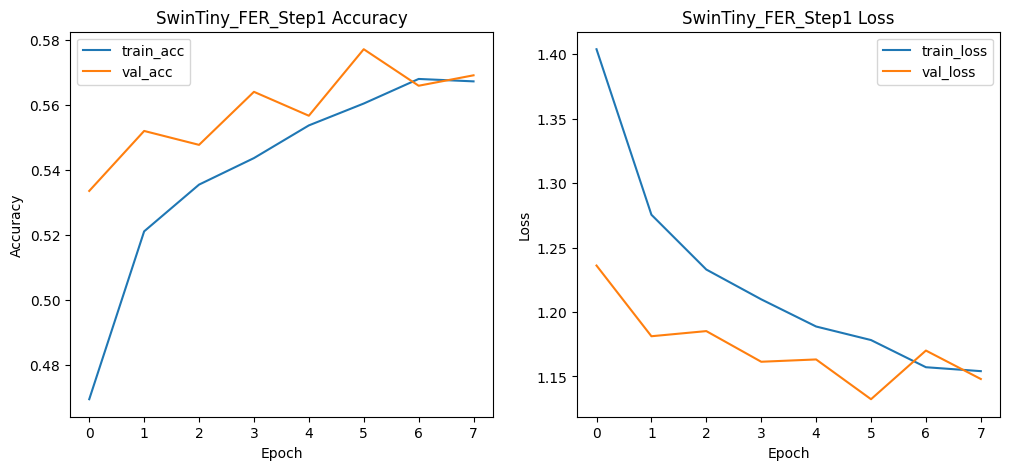

In [ ]:
# ---------------- "omg! it took his first step!" ----------------#

# -------------------
# CONFIG
# -------------------
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
PATIENCE = 2

# Construct full path for checkpoint using the pre-defined models_path
CHECKPOINT_PATH = MODELS_PATH/"step1_swin.pth"
print(f"[INFO] Checkpoint will be saved to: {CHECKPOINT_PATH}")

# -------------------
# MODEL SETUP
# -------------------
# Freeze Backbone
for param in model_with_head.backbone.parameters():
    param.requires_grad = False

model_with_head.to(DEVICE)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_with_head.parameters()),
    lr=1e-3
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------
# TRAINING LOOP
# -------------------
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc, trigger_times = 0, 0

for epoch in range(EPOCHS):
    # ---- Training ----
    model_with_head.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Augmentations on GPU
        images = train_aug(images)

        optimizer.zero_grad()
        outputs = model_with_head(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---- Validation ----
    model_with_head.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_with_head(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # ---- Early Stopping & Saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model_with_head.state_dict(), CHECKPOINT_PATH)
        print(f"--> Best model saved to {CHECKPOINT_PATH}")
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Plot results
plot_training_history_torch(train_accs, val_accs, train_losses, val_losses, "SwinTiny_FER_Step1")

### 4.2 - Step 2 - Fine Tune Training

Stage 2 - Fine-tuning: After the classification head has converged, we unfreeze some of the top layers of the base model and continue training with a much lower learning rate (1e-4). This allows the pre-trained features to adapt slightly to our specific task without destroying the learned representations.


[INFO] Step 2 checkpoints will be saved to: /content/drive/MyDrive/Colab Notebooks/project_2_models/step2_swin.pth
[START] No Step 2 checkpoint found. Loading Step 1 Model.
[INFO] Trainable parameters: 27,618,689
Epoch 1: Train Loss=1.1220 Acc=0.5900 | Val Loss=0.9015 Acc=0.6797
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step2_swin.pth
Epoch 2: Train Loss=0.9438 Acc=0.6634 | Val Loss=0.8223 Acc=0.6983
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step2_swin.pth
Epoch 3: Train Loss=0.8555 Acc=0.6934 | Val Loss=0.7810 Acc=0.7114
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step2_swin.pth
Epoch 4: Train Loss=0.8137 Acc=0.7088 | Val Loss=0.8697 Acc=0.6869
Epoch 5: Train Loss=0.7855 Acc=0.7167 | Val Loss=0.7619 Acc=0.7228
--> Best model saved to /content/drive/MyDrive/Colab Notebooks/project_2_models/step2_swin.pth
Epoch 6: Train Loss=0.7181 Acc=0.7423 | Val Loss=0.7551 Acc=0.7231
--> B

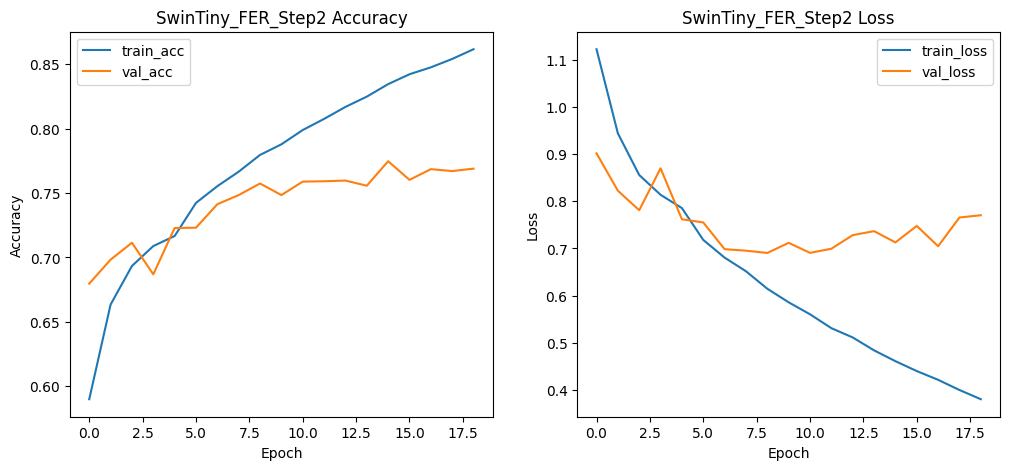

In [ ]:
# ---------------- 2nd step ----------------#
# -------------------
# CONFIG
# -------------------
CHECKPOINT_PATH = os.path.join(models_path, 'step2_swin.pth') # Output file
STEP1_PATH      = os.path.join(models_path, 'step1_swin.pth') # Input file
PATIENCE = 4
EPOCHS = 30

print(f"[INFO] Step 2 checkpoints will be saved to: {CHECKPOINT_PATH}")

# -------------------
# UNFREEZE UTILITY
# -------------------
def unfreeze_top_layers(model, num_layers_to_unfreeze):
    layers = list(model.backbone.children())
    # Freeze bottom (start of network)
    for layer in layers[:-num_layers_to_unfreeze]:
        for param in layer.parameters():
            param.requires_grad = False
    # Unfreeze top (end of network)
    for layer in layers[-num_layers_to_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

    trainable_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[INFO] Trainable parameters: {trainable_count:,}")
    return model

# -------------------
# SMART SETUP ("The Safe Switch")
# -------------------
# 1. Check if we are Resuming or Starting Fresh
start_epoch = 0
best_val_acc = 0.0

if os.path.exists(CHECKPOINT_PATH):
    print(f"[RESUME] Found existing Step 2 checkpoint at {CHECKPOINT_PATH}")
    print("[INFO] Loading Step 2 weights to continue fine-tuning...")
    model_with_head.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    # If resuming, we assume we want to beat the current saved model's performance
    # (You could technically load the saved acc here if you logged it, but 0 is safe)
else:
    print(f"[START] No Step 2 checkpoint found. Loading Step 1 Model.")
    if os.path.exists(STEP1_PATH):
        model_with_head.load_state_dict(torch.load(STEP1_PATH, map_location=DEVICE))
    else:
        raise FileNotFoundError(f"Missing Step 1 model at {STEP1_PATH}! Run Step 1 first.")

# 2. Apply Architecture Changes (Unfreeze)
# We do this regardless of whether we loaded Step 1 or Step 2 weights
model_with_head = unfreeze_top_layers(model_with_head, num_layers_to_unfreeze=5)
model_with_head.to(DEVICE)

# 3. Optimizer (Lower LR for Fine-tuning)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_with_head.parameters()),
    lr=1e-4  # Significantly lower than Step 1
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# -------------------
# TRAINING LOOP
# -------------------
train_losses, val_losses, train_accs, val_accs = [], [], [], []
trigger_times = 0

for epoch in range(EPOCHS):
    # ---- Training ----
    model_with_head.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply Kornia Augmentation
        images = train_aug(images)

        optimizer.zero_grad()
        outputs = model_with_head(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---- Validation ----
    model_with_head.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_with_head(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    # ---- Early Stopping & Saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model_with_head.state_dict(), CHECKPOINT_PATH)
        print(f"--> Best model saved to {CHECKPOINT_PATH}")
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print("Early stopping triggered.")
            break

plot_training_history_torch(train_accs, val_accs, train_losses, val_losses, "SwinTiny_FER_Step2")

### 4.3 Test Evaluation


[INFO] Evaluating on 7474 test images...

Test Accuracy: 78.04%

Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.62      0.69       889
     disgust       0.94      0.93      0.93       889
        fear       0.67      0.65      0.66       889
       happy       0.93      0.88      0.90      1711
     neutral       0.67      0.78      0.72      1226
         sad       0.63      0.69      0.65       981
    surprise       0.82      0.84      0.83       889

    accuracy                           0.78      7474
   macro avg       0.78      0.77      0.77      7474
weighted avg       0.79      0.78      0.78      7474



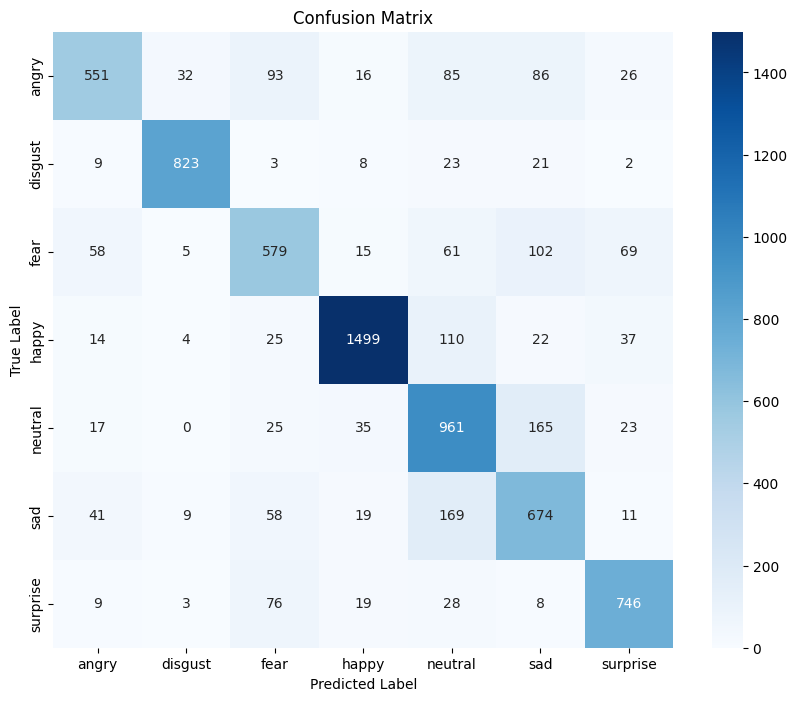

Most Confused Class Pairs:

True 'angry' → Predicted 'fear'   |   Confused 93 times
True 'disgust' → Predicted 'neutral'   |   Confused 23 times
True 'fear' → Predicted 'sad'   |   Confused 102 times
True 'happy' → Predicted 'neutral'   |   Confused 110 times
True 'neutral' → Predicted 'sad'   |   Confused 165 times
True 'sad' → Predicted 'neutral'   |   Confused 169 times
True 'surprise' → Predicted 'fear'   |   Confused 76 times


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------
# CONFIG
# -------------------
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------
# LOAD MODEL WEIGHTS
# -------------------
step_2_model_path = os.path.join(models_path, 'step2_swin.pth')
model_with_head.load_state_dict(torch.load(step_2_model_path, map_location=DEVICE))
model_with_head.to(DEVICE)
model_with_head.eval()

# -------------------
# INFERENCE
# -------------------
all_preds, all_labels = [], []
print(f"[INFO] Evaluating on {len(test_loader.dataset)} test images...")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_with_head(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -------------------
# METRICS & PLOTS
# -------------------
acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# -------------------
# Most confused pairs
# -------------------

CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
confusion_pairs = []

for i in range(len(CLASS_NAMES)):
    row = cm[i].copy()
    row[i] = 0  # ignore correct predictions
    most_confused = np.argmax(row)
    count = row[most_confused]

    confusion_pairs.append({
        "true_class": CLASS_NAMES[i],
        "predicted_as": CLASS_NAMES[most_confused],
        "count": int(count)
    })

print("Most Confused Class Pairs:\n")
for item in confusion_pairs:
    t = item["true_class"]
    p = item["predicted_as"]
    c = item["count"]
    print(f"True '{t}' → Predicted '{p}'   |   Confused {c} times")


### 4.5 Untrained, step 1, and step 2 comparison

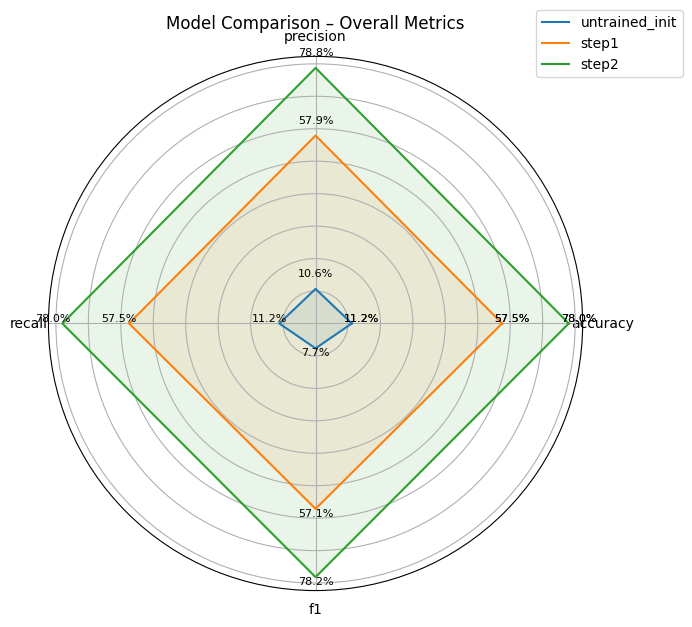

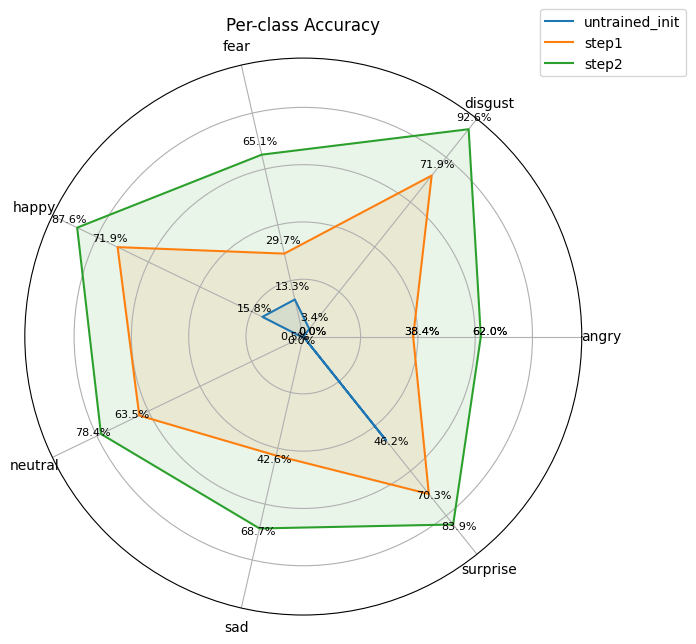

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

models = {
    "untrained_init": "swin_tiny_untrained_init.pth",
    "step1": "step1_swin.pth",
    "step2": "step2_swin.pth"
}

# ----------------------------------------------------
# MODEL EVALUATION
# ----------------------------------------------------
def evaluate_model(model, loader, device):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average='weighted'),
        "recall": recall_score(all_labels, all_preds, average='weighted'),
        "f1": f1_score(all_labels, all_preds, average='weighted')
    }

    per_class_acc = []
    for i in range(len(CLASS_NAMES)):
        idx = all_labels == i
        acc = accuracy_score(all_labels[idx], all_preds[idx])
        per_class_acc.append(acc)

    return metrics, per_class_acc


# ----------------------------------------------------
# EVALUATE ALL MODELS
# ----------------------------------------------------
results = {}
per_class_results = {}

for name, path in models.items():
    model_with_head.load_state_dict(torch.load(os.path.join(models_path, path), map_location=DEVICE))
    metrics, per_class_acc = evaluate_model(model_with_head, test_loader, DEVICE)
    results[name] = metrics
    per_class_results[name] = per_class_acc


# ----------------------------------------------------
# RADAR PLOT – OVERALL METRICS
# ----------------------------------------------------
categories = ['accuracy', 'precision', 'recall', 'f1']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for name, metrics in results.items():
    values = [metrics[c] for c in categories]
    values += values[:1]
    ax.plot(angles, values, label=name)
    ax.fill(angles, values, alpha=0.1)

    for ang, val in zip(angles, values):
        ax.text(ang, val + 0.03, f"{val*100:.1f}%", ha='center', va='bottom', fontsize=8)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticklabels([])
ax.set_title("Model Comparison – Overall Metrics", pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


# ----------------------------------------------------
# RADAR PLOT – PER-CLASS ACCURACY
# ----------------------------------------------------
plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

N = len(CLASS_NAMES)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

for name, acc_list in per_class_results.items():
    values = acc_list + acc_list[:1]
    ax.plot(angles, values, label=name)
    ax.fill(angles, values, alpha=0.1)

    for ang, val in zip(angles, values):
        ax.text(ang, val + 0.03, f"{val*100:.1f}%", ha='center', va='bottom', fontsize=8)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(CLASS_NAMES)
ax.set_yticklabels([])
ax.set_title("Per-class Accuracy", pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()
